In [1]:
#loading the data 
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

DIR='C://Users//imdin//OneDrive//Documents//GAMS//Kidney_stone_detection-main//CT_Scan'
CATEGORIES=["Normal","Kidney_stone"]
training_data=[]

def train_data():
    for categories in CATEGORIES:
        path=os.path.join(DIR,categories)
        class_num=CATEGORIES.index(categories)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(128,128))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
train_data()
random.shuffle(training_data)
#im using random shuffle just to prevent overfitting isssues

In [2]:
X=[]
y=[]
for features,labels in training_data:
    X.append(features)
    y.append(labels)
X=np.array(X)
y=np.array(y)

In [3]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.1,random_state=1)
print(len(Xtrain),len(Xtest),len(ytrain),len(ytest))
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)

1611 179 1611 179


In [4]:
#dimensions of Train and Test set
print("Shape of Xtrain:", Xtrain.shape)
print("Shape of Xtest:", Xtest.shape)
print("Shape of ytrain:", ytrain.shape)
print("Shape of ytest:", ytest.shape)


Shape of Xtrain: (1611, 128, 128, 3)
Shape of Xtest: (179, 128, 128, 3)
Shape of ytrain: (1611,)
Shape of ytest: (179,)


In [6]:
# required Libraries
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Conv2D, Flatten, Convolution2D, Activation
from keras.layers import Dropout, MaxPooling2D
from tensorflow.keras.applications import ResNet50,Xception
import pickle

In [6]:
# data preprocessing
def median_blur(img):
    mb = cv2.medianBlur(img, 1)
    res=hist(mb)
    return res
    
def hist(img):
    res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gamma_corrected = np.array(255*(res / 255) ** 2.5, dtype = 'uint8')
    thres=thresholding_img(gamma_corrected)
    return thres

def thresholding_img(img):
    ret, thresh1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    return thresh1

processed_img=[]
for img in Xtrain:
    res=median_blur(img)
    processed_img.append(res)
    
processed_img=np.array(processed_img)

In [7]:
#data preprocessing
def preprocess_images(images):
    # Ensure images have 4 dimensions
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)

    # Stack the grayscale images across the channel dimension
    images_stacked = np.repeat(images, 3, axis=-1)

    # Resize the images to the input size expected by VGG16
    images_resized = np.array([cv2.resize(img, (224, 224)) for img in images_stacked])
    return images_resized



In [8]:
# model building
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import cv2

# Function to preprocess the images for VGG16
def preprocess_images(images):
    # Resize the images to the input size expected by VGG16
    images_resized = np.array([cv2.resize(img, (224, 224)) for img in images])
    # Normalize pixel values to the range [0, 1]
    images_resized = images_resized / 255.0
    return images_resized

# Preprocess the training and testing sets
Xtrain_preprocessed = preprocess_images(Xtrain)
Xtest_preprocessed = preprocess_images(Xtest)

# Load the VGG16 model with weights pre-trained on ImageNet, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the input layer for your model
inputs = Input(shape=(224, 224, 3))

# Add the base model as the core of your new model
x = base_model(inputs)

# Add custom top layers for binary classification
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Construct the new model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to check the architecture
model.summary()

# Train the model
# Note: Ensure your ytrain and ytest are correct shape and type for binary crossentropy
model.fit(Xtrain_preprocessed, ytrain, batch_size=32, epochs=10, validation_data=(Xtest_preprocessed, ytest))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5296 - loss: 2.2062 - val_accuracy: 0.6983 - val_loss: 0.5754
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6985 - loss: 0.5878 - val_accuracy: 0.7039 - val_loss: 0.5421
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7428 - loss: 0.5312 - val_accuracy: 0.7933 - val_loss: 0.5121
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7688 - loss: 0.4863 - val_accuracy: 0.7374 - val_loss: 0.5424
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7728 - loss: 0.4631 - val_accuracy: 0.7877 - val_loss: 0.4492
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8515 - loss: 0.3643 - val_accuracy: 0.7709 - val_loss: 0.4650
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8706 - loss: 0.3178 - val_accuracy: 0.7933 - val_loss: 0.4379
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8887 - loss: 0.2821 - val_accuracy: 0.7765 - val_loss:

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9044 - loss: 0.2514 - val_accuracy: 0.8268 - val_loss: 0.3896
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9384 - loss: 0.1866 - val_accuracy: 0.8156 - val_loss: 0.4177
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9325 - loss: 0.1956 - val_accuracy: 0.8436 - val_loss: 0.4153
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9266 - loss: 0.1783 - val_accuracy: 0.8268 - val_loss: 0.4458
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9357 - loss: 0.1663 - val_accuracy: 0.8547 - val_loss: 0.3696
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9514 - loss: 0.1449 - val_accuracy: 0.8492 - val_loss: 0.3696
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9531 - loss: 0.1309 - val_accuracy: 0.8547 - val_loss: 0.3768
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9661 - loss: 0.1075 - val_accuracy: 0.8324 - val_loss:

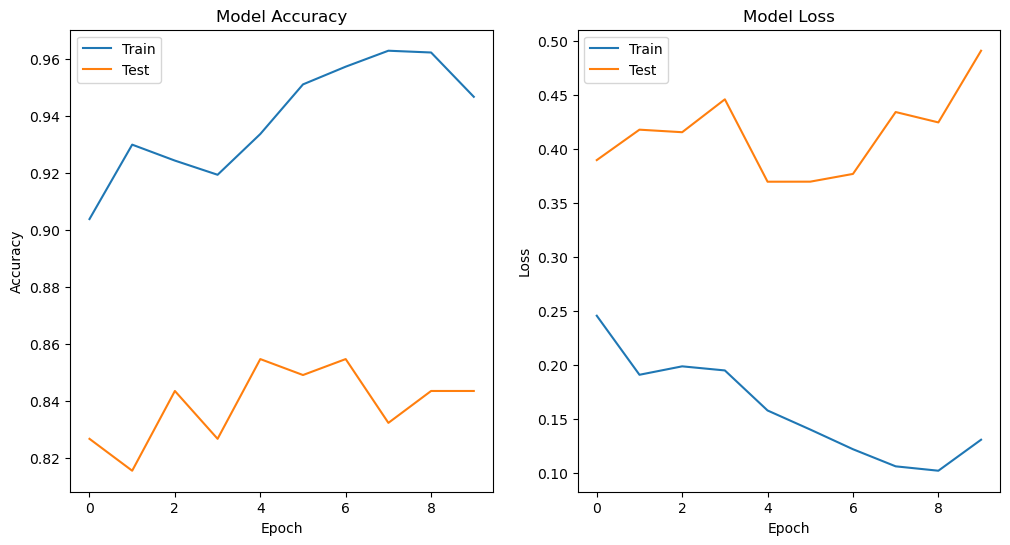

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
              precision    recall  f1-score   support

      Normal       0.78      0.98      0.87        95
Kidney_stone       0.97      0.69      0.81        84

    accuracy                           0.84       179
   macro avg       0.87      0.83      0.84       179
weighted avg       0.87      0.84      0.84       179

Confusion Matrix:
[[93  2]
 [26 58]]


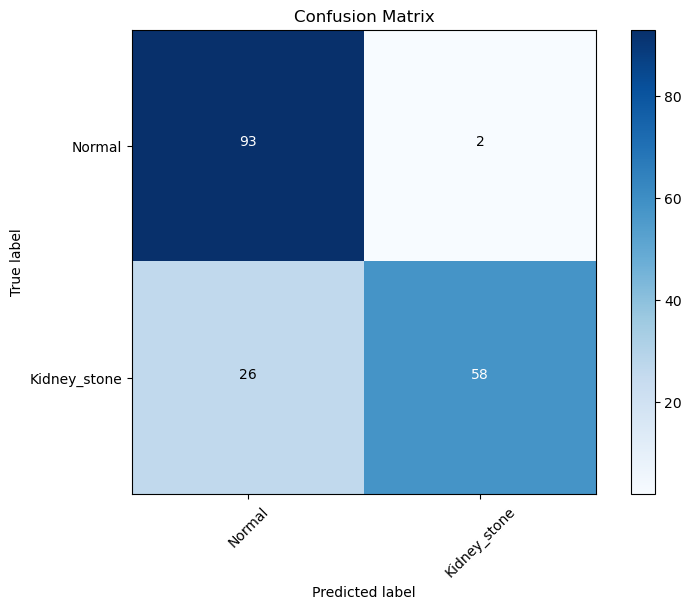

In [9]:
#model metrics, graphs, CM
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import itertools

# Assuming model.fit() is stored in a variable 'history'
history = model.fit(Xtrain_preprocessed, ytrain, batch_size=32, epochs=10, validation_data=(Xtest_preprocessed, ytest))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Generate predictions
y_pred = model.predict(Xtest_preprocessed)
# Convert predictions from probabilities to binary predictions using your threshold method
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Print classification report
print(classification_report(ytest, y_pred_binary, target_names=CATEGORIES))

# Generate and print the confusion matrix using your approach
conf_matrix = confusion_matrix(ytest, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CATEGORIES))
plt.xticks(tick_marks, CATEGORIES, rotation=45)
plt.yticks(tick_marks, CATEGORIES)

# Annotate the confusion matrix with text
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


              precision    recall  f1-score   support

      Normal       0.90      0.94      0.92       104
Kidney_stone       0.91      0.85      0.88        75

    accuracy                           0.91       179
   macro avg       0.91      0.90      0.90       179
weighted avg       0.91      0.91      0.90       179

[[98  6]
 [11 64]]


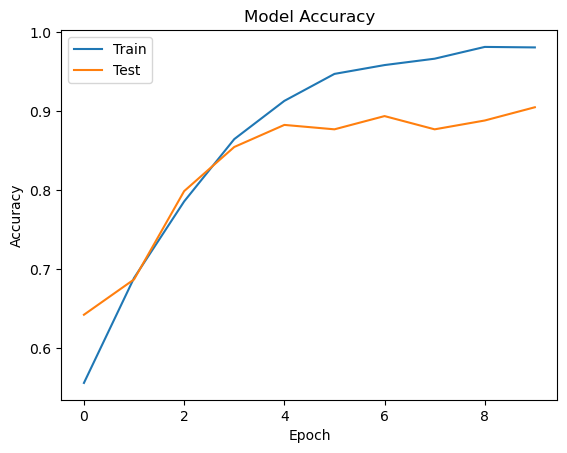

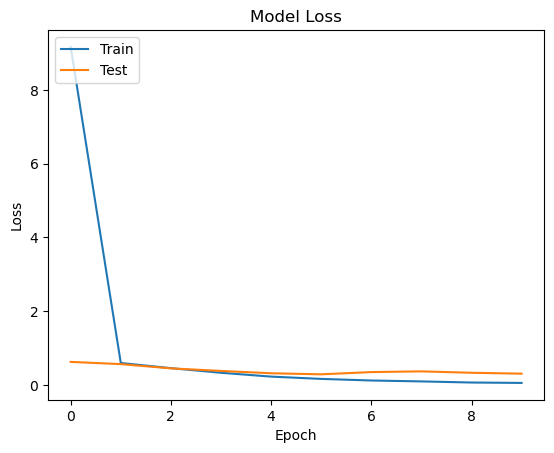